In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns       
from datetime import datetime

from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error

from mlxtend.regressor import StackingCVRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline  

D:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
data = {
    'tra': pd.read_csv('../data/train.csv',engine='python'),
    'tes': pd.read_csv('../data/test.csv',engine='python')
}

In [3]:
data['tra'].head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
data['tes'].head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
#檢查特徵&資料的數量
print("The train data size before dropping Id feature is : {} ".format(data['tra'].shape))
print("The test data size before dropping Id feature is : {} ".format(data['tes'].shape))

#Save the 'Id' column
train_ID = data['tra']['Id']
test_ID = data['tes']['Id']

# 拿掉'Id'這個特徵，因為這個特徵沒有意義
data['tra'].drop("Id", axis = 1, inplace = True)
data['tes'].drop("Id", axis = 1, inplace = True)

#檢查拿掉'Id'後特徵&資料的數量
print("\nThe train data size after dropping Id feature is : {} ".format(data['tra'].shape)) 
print("The test data size after dropping Id feature is : {} ".format(data['tes'].shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


### 分析'SalePrice'

In [6]:
data['tra']['SalePrice'].describe() # 從結果可以發現，'SalePrice'沒有 missing value 或非數值的數據。

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

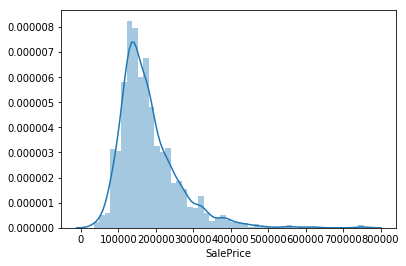

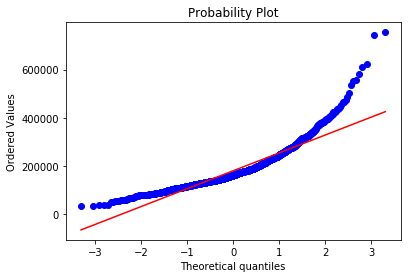

In [7]:
sns.distplot(data['tra']['SalePrice'])

fig = plt.figure()
res = stats.probplot(data['tra']['SalePrice'], plot=plt)
plt.show()

In [8]:
#skewness and kurtosis
print("Skewness: %f" % data['tra']['SalePrice'].skew())
print("Kurtosis: %f" % data['tra']['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


* 偏態(Skewness):
	偏態是用來說明一組數據分布的型態。
	- 單峰分布有三種型態的偏態:
		1. 對稱:平均數=中位數
		2. 右偏(正偏):平均數>中位數
		3. 左偏(負偏):平均數<中位數
	- 偏態係數
		- 偏態係數 = 0 ，表示樣本分布是對稱的，即正態分布。
		- 偏態係數 > 0，表示樣本分布是偏右的，即長尾巴在右邊。
		- 偏態係數 < 0，表示樣本分布是偏左的，即長尾巴在左邊。

* 峰度(Kurtosis):
	峰度是用來說明一組數據分布型態的陡緩程度。
	- 峰度係數:
		- 峰度係數 = 0，表示與正態分布的陡緩程度相同。
		- 峰度係數 > 0，表示比正態分布的高峰更陡峭 — 尖頂峰。
		- 峰度係數 < 0，表示比正態分布的高峰來的平緩 — 平頂峰。
        
將偏態和峰度的計算結果和圖形對比，可知道長尾巴的確在右邊，證明<font color=red>房價呈現右偏</font>。

在處理房價右偏問題前，我們先來看看'SalePrice'和'GrLivArea'的關係

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


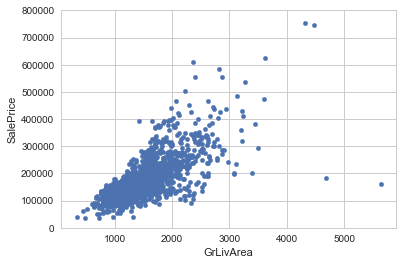

In [9]:
tmp = pd.concat([data['tra']['SalePrice'], data['tra']['GrLivArea']], axis=1)
sns.set(style="whitegrid")
tmp.plot.scatter(x='GrLivArea', y="SalePrice", ylim=(0, 800000))
plt.show()

由上圖可以知道'GrLivArea'和'SalePrice'大致上程線性增加的關係，這個特性非常符合我們生活中的真實情況，即土地越大房價越高。但是右下角有二個例外(極端值)，這二個極端值的'GrLivArea'都很大，但房價卻很低，為了避免這二個巨大極端值的影響在這裡我們將他刪除。

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


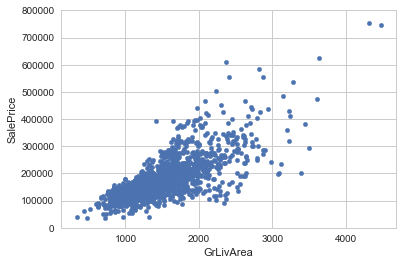

In [10]:
# 移除極端值
data['tra'] = data['tra'].drop(data['tra'][(data['tra']['GrLivArea']>4000) & (data['tra']['SalePrice']<300000)].index)
# data['tra'] = data['tra'][data['tra'].GrLivArea < 4500]
data['tra'].reset_index(drop=True, inplace=True)

tmp = pd.concat([data['tra']['SalePrice'], data['tra']['GrLivArea']], axis=1)
sns.set(style="whitegrid")
tmp.plot.scatter(x='GrLivArea', y="SalePrice", ylim=(0, 800000))
plt.show()

移除極端值後，接下來就可以處理房價右偏的問題，我們會希望他能夠趨近常態分佈，因為線性回歸適合預測常態分佈的數據(?)

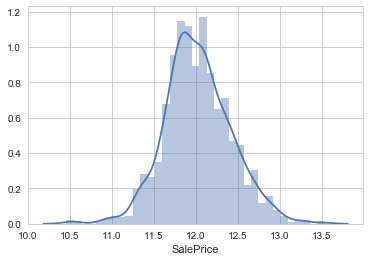

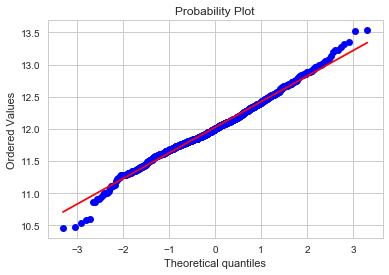

In [11]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
data['tra']["SalePrice"] = np.log1p(data['tra']["SalePrice"])
y = data['tra'].SalePrice.reset_index(drop=True)

sns.distplot(data['tra']['SalePrice'])

fig = plt.figure()
res = stats.probplot(data['tra']['SalePrice'], plot=plt)
plt.show()

### 合併 train 和 test data
為了保持訓練集和測試集的一致性

In [12]:
ntrain = data['tra'].shape[0]
ntest = data['tes'].shape[0]

x_train = data['tra'].drop(['SalePrice'], axis=1)
y_train = data['tra'].SalePrice

all_data = pd.concat((data['tra'], data['tes'])).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


In [13]:
# Some of the non-numeric predictors are stored as numbers; we convert them into strings (categorical features)
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

### Missing Value

計算每個特徵有多少比例的missing value，排序後顯示前10名。

In [14]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(10)

,Missing Ratio
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageQual,5.450806
GarageCond,5.450806
GarageFinish,5.450806
GarageYrBlt,5.450806


Text(0.5, 1.0, 'Percent missing data by feature')

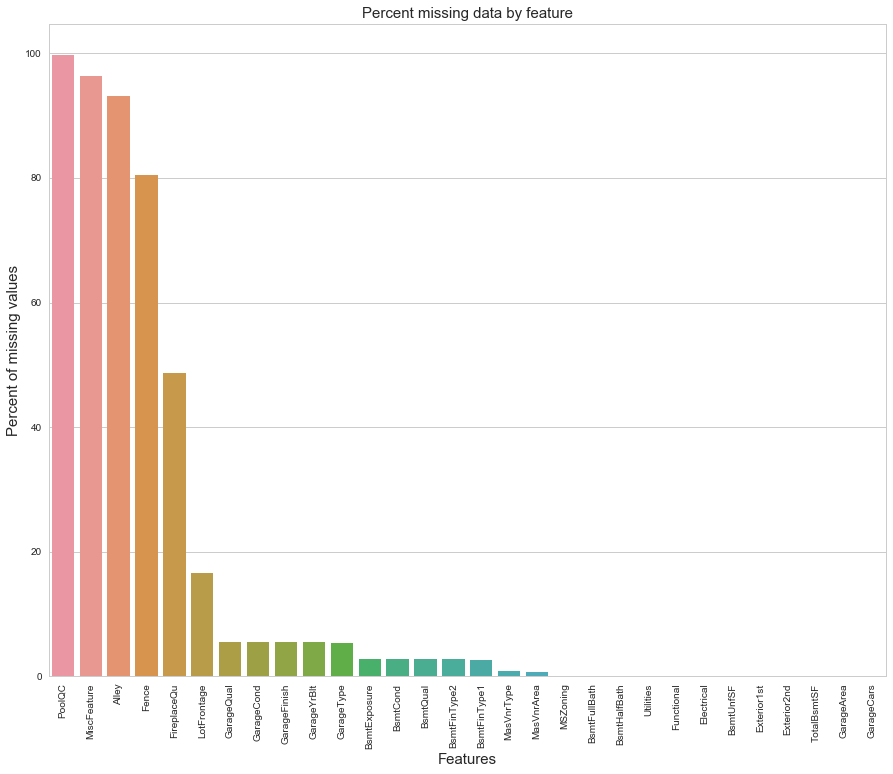

In [15]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

有些特徵有missing value的原因是因為沒有這一項東西(在data description 中有說明某些特徵的NA代表沒有這一項物品)，所以我們可以將這一類型特徵的NA都填成None

In [16]:
# None代表沒有游泳池
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

In [17]:
# 沒車庫
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

# 沒有車庫就不會有這些東西
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

In [18]:
# 沒地下室
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')
    
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
     all_data[col] = all_data[col].fillna(0)

Functional : data description 內有提到 NA 代表 typical

In [19]:
all_data['Functional'] = all_data['Functional'].fillna('Typ')

填入最常出現的類別

In [20]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

all_data['MSZoning'] = all_data.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

KitchenQual: 只有一個NA值 , 我們可以填出現最多次的類別('TA')。
Electrical : 只有一個NA值 , 我們可以填出現最多次的類別('SBrkr')。

In [21]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna("TA")
all_data['Electrical'] = all_data['Electrical'].fillna("SBrkr")

其他object型態的missing value都填None

In [22]:
objects = []
for i in all_data.columns:
    if all_data[i].dtype == object:
        objects.append(i)

all_data.update(all_data[objects].fillna('None'))

由於連接到房產的每條街道的區域很可能與其他附近的房屋具有相似的區域，所以我們可以用neighborhood和LotFrontage的中位數來填補

In [23]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

其他數值型態的missing value都填0

In [24]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in all_data.columns:
    if all_data[i].dtype in numeric_dtypes:
        numerics.append(i)
        
all_data.update(all_data[numerics].fillna(0))

### Skewed features

In [25]:
numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in all_data.columns:
    if all_data[i].dtype in numeric_dtypes:
        numerics2.append(i)

skew_features = all_data[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)
skews = pd.DataFrame({'skew':skew_features})
skews

,skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101
BsmtHalfBath,3.929996


In [26]:
high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    all_data[i] = boxcox1p(all_data[i], boxcox_normmax(all_data[i] + 1))
    
skew_features2 = all_data[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)
skews2 = pd.DataFrame({'skew':skew_features2})
skews2

,skew
PoolArea,15.595057
3SsnPorch,8.862045
LowQualFinSF,8.492615
MiscVal,5.237983
BsmtHalfBath,3.779434
KitchenAbvGr,3.778336
ScreenPorch,3.152631
BsmtFinSF2,2.578329
EnclosedPorch,2.149133
MasVnrArea,0.977618


### Drop features

In [27]:
all_data = all_data.drop(['Utilities', 'Street', 'PoolQC', ], axis=1)

### Add new features

In [28]:
all_data['YrBltAndRemod'] = all_data['YearBuilt'] + all_data['YearRemodAdd']

all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

all_data['Total_sqr_footage'] = (all_data['BsmtFinSF1'] + all_data['BsmtFinSF2'] +
                                 all_data['1stFlrSF'] + all_data['2ndFlrSF'])

all_data['Total_Bathrooms'] = (all_data['FullBath'] + (0.5*all_data['HalfBath']) + 
                               all_data['BsmtFullBath'] + (0.5*all_data['BsmtHalfBath']))

all_data['Total_porch_sf'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] +
                              all_data['EnclosedPorch'] + all_data['ScreenPorch'] +
                             all_data['WoodDeckSF'])

### simplified features

In [29]:
all_data['haspool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['has2ndfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasgarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasbsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

### One-hot-encoding

In [30]:
all_data = pd.get_dummies(all_data).reset_index(drop=True)
print(all_data.shape)

(2917, 333)


### Split data into train and test

In [31]:
X = all_data.iloc[:ntrain]
X_sub = all_data.iloc[ntrain:]
# y = y_train
print('X', X.shape, 'y', y.shape, 'X_sub', X_sub.shape)

X (1458, 333) y (1458,) X_sub (1459, 333)


In [32]:
outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

In [33]:
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
overfit.append('MSZoning_C (all)')

In [34]:
X = X.drop(overfit, axis=1).copy()
X_sub = X_sub.drop(overfit, axis=1).copy()

In [35]:
print('X', X.shape, 'y', y.shape, 'X_sub', X_sub.shape)

X (1453, 331) y (1453,) X_sub (1459, 331)


### Model

In [36]:
print('START MODEL', datetime.now(), )

kfolds = KFold(n_splits=10, shuffle=True, random_state=42)


# rmsle
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


# build our model scoring function
def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y,
                                    scoring="neg_mean_squared_error",
                                    cv=kfolds))
    return (rmse)

START MODEL 2019-03-27 14:32:00.827741


### Setup models

In [37]:
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [38]:
ridge = make_pipeline(RobustScaler(),
                      RidgeCV(alphas=alphas_alt, cv=kfolds, ))

In [39]:
lasso = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=1e7, alphas=alphas2,
                              random_state=42, cv=kfolds))

In [40]:
elasticnet = make_pipeline(RobustScaler(),
                           ElasticNetCV(max_iter=1e7, alphas=e_alphas,
                                        cv=kfolds, random_state=42, l1_ratio=e_l1ratio))

In [41]:
svr = make_pipeline(RobustScaler(),
                    SVR(C=20, epsilon=0.008, gamma=0.0003, ))

In [42]:
gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                max_depth=4, max_features='sqrt',
                                min_samples_leaf=15, min_samples_split=10,
                                loss='huber', random_state=42)

In [43]:
lightgbm = LGBMRegressor(objective='regression',
                         num_leaves=4,
                         learning_rate=0.01,
                         n_estimators=5000,
                         max_bin=200,
                         bagging_fraction=0.75,
                         bagging_freq=5,
                         bagging_seed=7,
                         feature_fraction=0.2,
                         feature_fraction_seed=7,
                         verbose=-1
                         )

In [44]:
xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                       max_depth=3, min_child_weight=0,
                       gamma=0, subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear', nthread=-1,
                       scale_pos_weight=1, seed=27,
                       reg_alpha=0.00006, random_state=42)

In [45]:
# stack
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet,
                                            gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

### TEST score on CV

In [46]:
score = cv_rmse(ridge)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

Kernel Ridge score: 0.1024 (0.0143)
 2019-03-27 14:32:34.454375


In [47]:
score = cv_rmse(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

Lasso score: 0.1031 (0.0147)
 2019-03-27 14:32:54.647778


In [48]:
score = cv_rmse(elasticnet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

ElasticNet score: 0.1031 (0.0149)
 2019-03-27 14:34:15.382912


In [49]:
score = cv_rmse(svr)
print("SVR score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

SVR score: 0.1023 (0.0133)
 2019-03-27 14:34:36.959938


In [50]:
score = cv_rmse(gbr)
print("GradientBoosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

GradientBoosting score: 0.1079 (0.0132)
 2019-03-27 14:37:22.950734


In [51]:
score = cv_rmse(lightgbm)
print("Lightgbm score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

Lightgbm score: 0.1057 (0.0149)
 2019-03-27 14:37:42.498093


In [52]:
score = cv_rmse(xgboost)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

Xgboost score: 0.1069 (0.0164)
 2019-03-27 14:39:57.330843


### Fit Model

In [53]:
print(datetime.now(), 'StackingCVRegressor')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))

2019-03-27 14:39:57.348561 StackingCVRegressor


In [54]:
print(datetime.now(), 'elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)

2019-03-27 14:44:39.418676 elasticnet


In [55]:
print(datetime.now(), 'lasso')
lasso_model_full_data = lasso.fit(X, y)

2019-03-27 14:44:48.285589 lasso


In [56]:
print(datetime.now(), 'ridge')
ridge_model_full_data = ridge.fit(X, y)

2019-03-27 14:44:50.291169 ridge


In [57]:
print(datetime.now(), 'svr')
svr_model_full_data = svr.fit(X, y)

2019-03-27 14:44:54.176428 svr


In [58]:
print(datetime.now(), 'GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)

2019-03-27 14:44:56.600780 GradientBoosting


In [59]:
print(datetime.now(), 'lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

2019-03-27 14:45:14.625363 lightgbm


In [60]:
print(datetime.now(), 'xgboost')
xgb_model_full_data = xgboost.fit(X, y)

2019-03-27 14:45:16.632221 xgboost


### Blend models prediction

In [61]:
def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) + \
            (0.05 * lasso_model_full_data.predict(X)) + \
            (0.1 * ridge_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.15 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.3 * stack_gen_model.predict(np.array(X))))

print('RMSLE score on train data:')
print(rmsle(y, blend_models_predict(X)))

RMSLE score on train data:
0.05719241367931311


### Submission

In [62]:
print('Predict submission', datetime.now(), )
submission = pd.read_csv("../data/sample_submission.csv",engine='python')
submission.iloc[:, 1] = np.floor(np.expm1(blend_models_predict(X_sub)))

# mixing with some top kernels

print('Blend with Top Kernals submissions', datetime.now(), )
sub_1 = pd.read_csv('../other_prediction/House_Prices_submit.csv',engine='python')
sub_2 = pd.read_csv('../other_prediction/hybrid_solution.csv',engine='python')
sub_3 = pd.read_csv('../other_prediction/lasso_sol22_Median.csv',engine='python')


submission.iloc[:, 1] = np.floor((0.25 * np.floor(np.expm1(blend_models_predict(X_sub)))) +
                                 (0.25 * sub_1.iloc[:, 1]) +
                                 (0.25 * sub_2.iloc[:, 1]) +
                                 (0.25 * sub_3.iloc[:, 1])
                                 )

# From https://www.kaggle.com/agehsbarg/top-10-0-10943-stacking-mice-and-brutal-force
# Brutal approach to deal with predictions close to outer range
q1 = submission['SalePrice'].quantile(0.0042)
q2 = submission['SalePrice'].quantile(0.99)

submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x > q1 else x * 0.60)
submission['SalePrice'] = submission['SalePrice'].apply(lambda x: x if x < q2 else x * 1.1)


submission.to_csv("../submissions/submission.csv", index=False)
print('Save submission', datetime.now(), )

Predict submission 2019-03-27 14:45:35.803208
Blend with Top Kernals submissions 2019-03-27 14:45:39.182366
Save submission 2019-03-27 14:45:42.563991
